# Задача 5. Обучение без учителя

- [ ] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [ ] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [ ] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Датасет

Для выполнения задания был взят [датасет с иероглифами хираганы](https://www.kaggle.com/datasets/notshrirang/japanese-characters?select=train_data.csv)

Он содержит в себе изображения символов хираганы размером 28х28 дюймов 10 различных классов:

1) Aa
1) Ka
1) Sa
1) Ta
1) Na
1) Ha
1) Ma
1) Ya
1) Ra
1) Wa

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClusterMixin, clone
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

import pathlib
import itertools
import time

import warnings

warnings.filterwarnings('ignore')

In [63]:
df = pd.read_csv("../data/hiragana/train_data.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
X = df.drop(['label'], axis=1)
y = df['label']

## Разведочный анализ данных (EDA)

In [64]:
df

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,8,0,0,0,0,0,0,0,0,0,...,122,255,90,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,32,...,255,64,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,4,0,0,0,0,0,103,225,53,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df.duplicated().sum()

0

In [66]:
df.isnull().sum().sum()

0

In [67]:
y.value_counts()

8    6000
7    6000
0    6000
1    6000
4    6000
2    6000
5    6000
6    6000
9    6000
3    6000
Name: label, dtype: int64

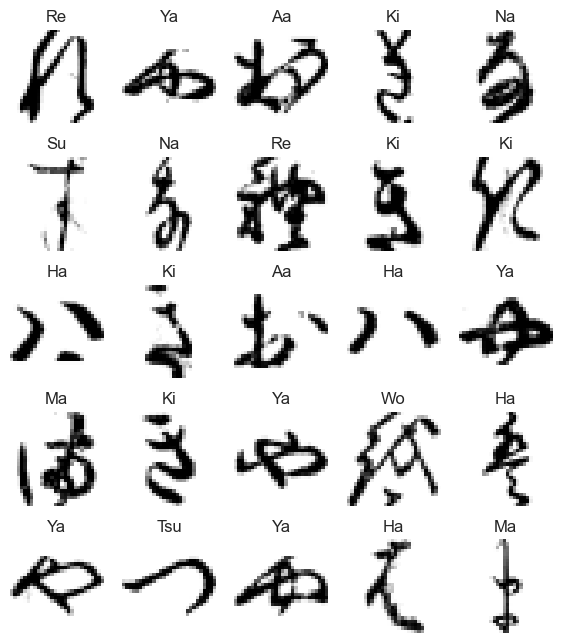

In [68]:
classes = ["Aa", "Ki", "Su", "Tsu", "Na", "Ha", "Ma", "Ya", "Re", "Wo"]
img_dim = int(np.sqrt(len(df.columns)))
img_size = (img_dim, img_dim)
plt.figure(figsize=(7, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.title(classes[y.iloc[i]], fontsize=12)
    img = X.iloc[i].to_numpy().reshape(img_size)
    plt.imshow(img, cmap=plt.cm.binary)
plt.show()

Между символами одного класса можно заметить похожие детали, но иногда они различаются слишком сильно и взаимосвязь между ними уловить сложно. Буква Ki, к примеру, похожа на английскую букву i, отраженную по горизонтали с небольшими дополнениями, а буква Ya включает в себя овал.

## Снизим размерность датасета с помощью PCA и t-SNE

CPU times: total: 12.8 s
Wall time: 3.99 s


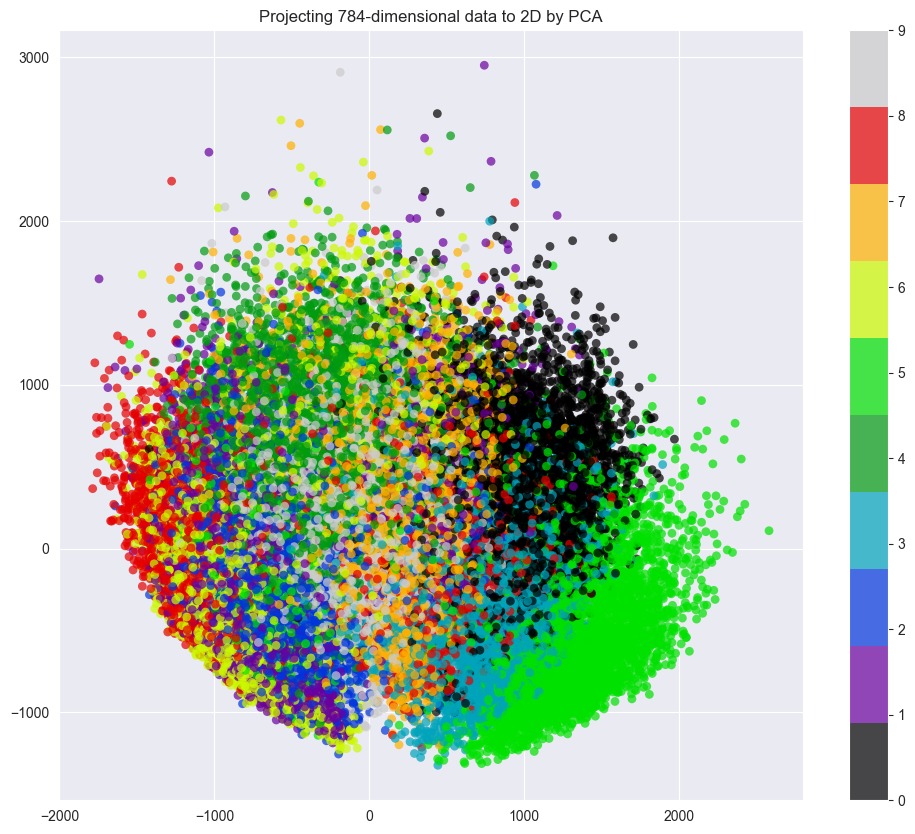

In [69]:
%%time

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Projecting %d-dimensional data to 2D by PCA' % X.shape[1]);

PCA сгруппировал все объекты в одну большую группу, где можно выделить преобладающий в определенном месте класс, но они слишком сильно пересекаются

CPU times: total: 47min 32s
Wall time: 4min 30s


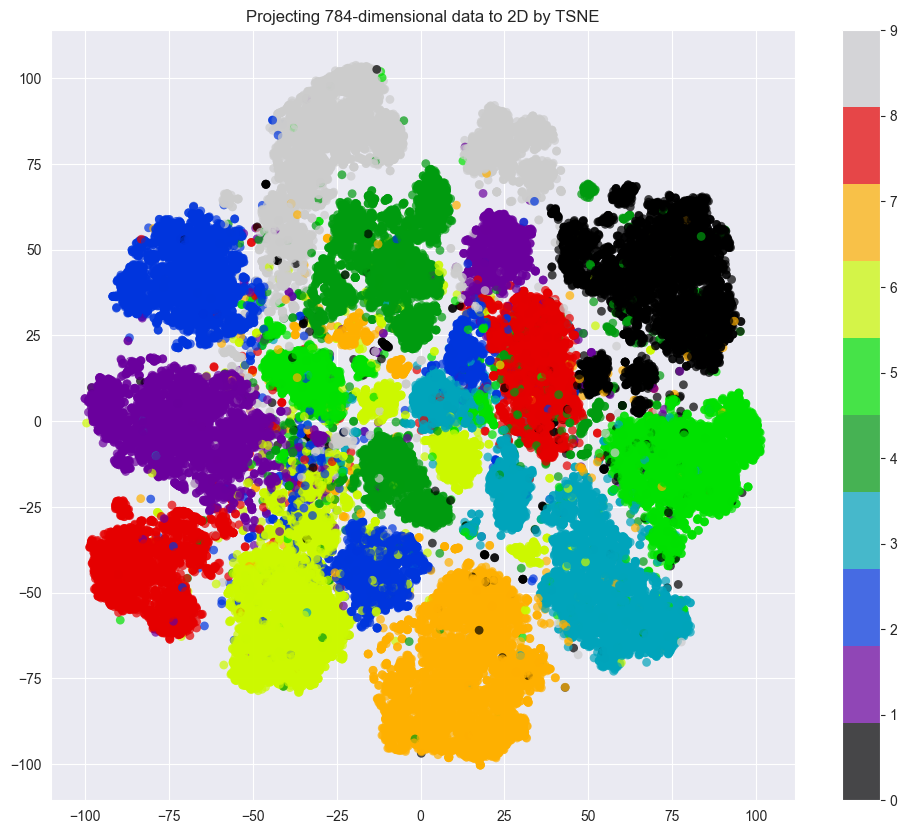

In [70]:
%%time

tsne = TSNE(random_state=42)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Projecting %d-dimensional data to 2D by TSNE' % X.shape[1]);

TSNE сгруппировал все по отдельным кучкам, хоть отдельные части и смешиваются, а части одного класса разделены на несколько групп

## Понижение размерности данных с помощью метода главных компонент
Посмотрим, все ли пиксели используются и насколько сильно в среднем они закрашены

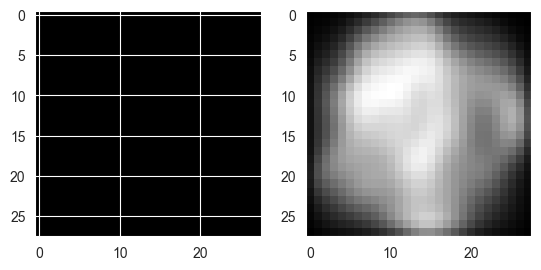

In [71]:
# plt.imshow(X.mean().values.reshape(img_size), cmap="gray")
# plt.grid(None)
fig, axs = plt.subplots(ncols=2)
for i, X_values in enumerate([X.max(), X.mean()]):
    axs[i].imshow(X_values.values.reshape(img_size), cmap="gray")
plt.grid(None)

В основном закрашенными являются центральные клетки, но так или иначе используются абсолютно все.

Посмотрим, какая часть пикселей содержит в себе основную часть информации.

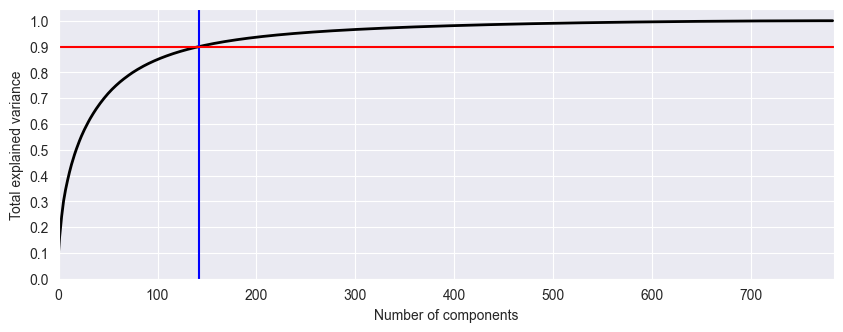

In [72]:
pca = PCA().fit(X)

plt.figure(figsize=(10, 3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, img_dim * img_dim)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(142, c='b')
plt.axhline(0.9, c='r')
plt.show();

Как можно заметить, 80 пикселей описывают более 80% дисперсии, 145 - более 90%, а приблизительно 500 описывают почти 100%.

## Реализация KMeans

In [73]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None, max_iter=300):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]
        self.cluster_centers_ = X[self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :]

        for _ in range(max_iter):
            self.labels_ = self._get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

            if max_center_shift <= self.tol:
                break

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))

    def _get_labels(self, X):
        return np.argmin(
            np.linalg.norm(X[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


check_estimator(MyKMeans())

## Обучение

In [74]:
%%time
Xs = [X, *(PCA(n_components=d).fit_transform(X) for d in [80, 145, 500])]

CPU times: total: 2min 37s
Wall time: 27.3 s


In [75]:
RESULTS_PATH = pathlib.Path("task05.csv")


def cross_validate(estimator, param_distributions):
    param_combs = [dict(params)
        for params in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in param_distributions.items()))
    ]

    results = []
    for x in Xs:
        best_ari, best_ami, best_fmi = None, None, None

        for params in param_combs:
            e = clone(estimator).set_params(**params)
            start_t = time.perf_counter()
            pred = e.fit_predict(x)
            fit_predict_time_s = (time.perf_counter() - start_t)
            ari = adjusted_rand_score(y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params
            ami = adjusted_mutual_info_score(y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params
            fmi = fowlkes_mallows_score(y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params

        res_dict = {
            "Clusterer_name": estimator.__class__.__name__,
            "Dimension": x.shape[1],
            "Fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0],
        }
        print(res_dict)
        results.append(res_dict)

    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a")

In [76]:
N_CLUSTERS = 10

In [77]:
%%time

cross_validate(MyKMeans(n_clusters=N_CLUSTERS, random_state=0),
               param_distributions={})

{'Clusterer': 'MyKMeans', 'Dimension': 784, 'Mean F/P time, s': 155.16187600000012, 'ARI': 0.3214363186218941, 'AMI': 0.4446214474575196, 'FMI': 0.3956061092187957}
{'Clusterer': 'MyKMeans', 'Dimension': 80, 'Mean F/P time, s': 16.54325719999997, 'ARI': 0.3209969517203514, 'AMI': 0.4440862250417948, 'FMI': 0.39513611344923866}
{'Clusterer': 'MyKMeans', 'Dimension': 145, 'Mean F/P time, s': 12.552262299999711, 'ARI': 0.3218307841686385, 'AMI': 0.4447361665549782, 'FMI': 0.39590872693039675}
{'Clusterer': 'MyKMeans', 'Dimension': 500, 'Mean F/P time, s': 77.76221189999978, 'ARI': 0.3214161741225112, 'AMI': 0.44463021120249585, 'FMI': 0.3955810536725613}
CPU times: total: 4min 4s
Wall time: 4min 22s


In [78]:
%%time

cross_validate(KMeans(n_clusters=N_CLUSTERS, n_init='auto', random_state=0),
               param_distributions={"algorithm": ["lloyd", "elkan"]})

{'Clusterer': 'KMeans', 'Dimension': 784, 'Mean F/P time, s': 2.615281700000196, 'ARI': 0.34434268258129386, 'AMI': 0.46889905331708703, 'FMI': 0.41581871551870314}
{'Clusterer': 'KMeans', 'Dimension': 80, 'Mean F/P time, s': 0.1822654000006878, 'ARI': 0.356273605193735, 'AMI': 0.45741844100499884, 'FMI': 0.4221739171862886}
{'Clusterer': 'KMeans', 'Dimension': 145, 'Mean F/P time, s': 0.32171889999972336, 'ARI': 0.34448067296560947, 'AMI': 0.46909533731602504, 'FMI': 0.41594381027599325}
{'Clusterer': 'KMeans', 'Dimension': 500, 'Mean F/P time, s': 1.2946191999999428, 'ARI': 0.3442979160384522, 'AMI': 0.46885232915810077, 'FMI': 0.4157697856871496}
CPU times: total: 1min 18s
Wall time: 9.06 s


In [79]:
%%time
cross_validate(DBSCAN(n_jobs=-1),
               param_distributions={"eps": [400, 800, 1200],
                           "min_samples": [20, 40, 80]})

{'Clusterer': 'DBSCAN', 'Dimension': 784, 'Mean F/P time, s': 82.9850683333334, 'ARI': 0.00219754238677229, 'AMI': 0.05447350950943012, 'FMI': 0.3162040476496084}
{'Clusterer': 'DBSCAN', 'Dimension': 80, 'Mean F/P time, s': 4.143340933333396, 'ARI': 0.02549293838570521, 'AMI': 0.07989938816810259, 'FMI': 0.3162040476496084}
{'Clusterer': 'DBSCAN', 'Dimension': 145, 'Mean F/P time, s': 7.281946466666341, 'ARI': 0.008526232752899947, 'AMI': 0.08174811957875217, 'FMI': 0.3162040476496084}
{'Clusterer': 'DBSCAN', 'Dimension': 500, 'Mean F/P time, s': 18.849128966666893, 'ARI': 0.002715986328939975, 'AMI': 0.06128160431526827, 'FMI': 0.3162040476496084}
CPU times: total: 2h 7min 11s
Wall time: 17min 2s


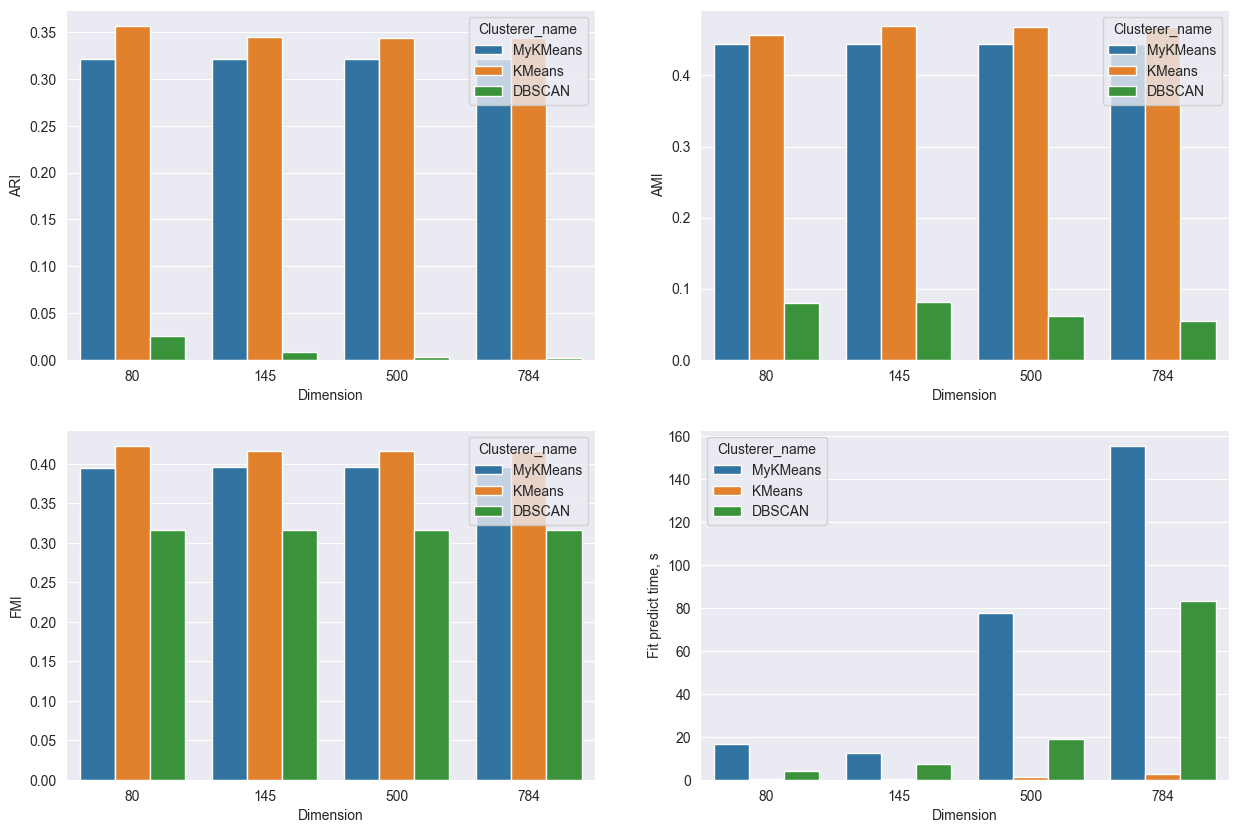

In [84]:
res = pd.read_csv(RESULTS_PATH)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for m_name, ax in zip(
        ["ARI", "AMI", "FMI", "Fit predict time, s"],
        axs.flatten(),
):
    sns.barplot(res, x="Dimension", y=m_name, hue="Clusterer_name", ax=ax)


Уменьшение размерности данных очень сильно сказалось на времени обучения, при этом минимально ухудшило результаты.

Дольше всех работал алгоритм MyKMeans, из-за не самого оптимизированного кода. DBSCAN тоже работал довольно длительное время, KMeans по сравнению с ними отработал почти мгновенно, секунды против минут.

Качественно обе реализации KMeans приблизительно равны, хоть собственная реализация чуточку и уступает реализации из skikit-learn, и сильно опережают алгоритм DBSCAN.
